In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
from src.coordinator import Coordinator
from src.utils.preprocessing import TextPreprocessor

In [7]:
coord = Coordinator()

In [34]:
df = pd.read_json(coord.data_processed.joinpath('processed_dataset_v1.jsonl'), lines=True)

In [35]:
df['user'].value_counts()

cnnbrk             13814
narendramodi       12636
realdonaldtrump    11616
theellenshow       10141
jimmyfallon         8110
youtube             7101
barackobama         6357
kimkardashian       5676
katyperry           5585
ladygaga            5461
justinbieber        5084
rihanna             4890
shakira             4387
arianagrande        4308
britneyspears       3159
selenagomez         2281
jtimberlake         2195
cristiano           2016
twitter             1840
taylorswift13        218
Name: user, dtype: int64

In [36]:
user_types = {'musicians': ['taylorswift13', 'shakira', 'selenagomez', 'rihanna', 'katyperry', 'justinbieber', 'jtimberlake', 'britneyspears', 
                            'arianagrande', 'ladygaga'], 
             'politician': ['realdonaldtrump', 'narendramodi', 'barackobama'],
             'brand': ['youtube', 'twitter', 'cnnbrk'], 
             'entertainer': ['jimmyfallon', 'theellenshow'],
             'media_personality': ['kimkardashian'],  
             'sportsperson': ['cristiano']}

def get_user_type(user):
    for user_type in user_types:
        if user in user_types[user_type]:
            return user_type

df['user_type'] = df['user'].apply(get_user_type)

In [37]:
df['user_type'].value_counts()

musicians            37568
politician           30609
brand                22755
entertainer          18251
media_personality     5676
sportsperson          2016
Name: user_type, dtype: int64

In [40]:
df.head(3)

,tweet_id,user,time_epoch,tweet,n_likes,n_retweets,n_replies,n_emojies,hashtags,mentions,user_type,tokenized_tweet
0,1247643096596111362,britneyspears,1586296268,Enough said 🧼🧼 and thank you to all of the hea...,86426,25499,960,5,"[#worldhealthday, #thankshealthheroes]",[],musicians,"[healthcare, worker, tirelessly, work, safe, t..."
1,1243706495793074182,britneyspears,1585357710,Oops!…how did 20 years go by so fast ?! I can...,122851,16256,2212,8,[],[],musicians,"[oops, year, fast, remember, red, suit, freak,..."
2,1243668424674459648,britneyspears,1585348633,Happy Birthday @MariahCarey !! You are one of ...,61079,7634,1345,1,[],[mariahcarey],musicians,"[happy, birthday, main, reason, start, sing, b..."


In [41]:
df = df[df['tokenized_tweet'].apply(lambda tweet: bool(tweet))]
df.shape

(116792, 12)

In [93]:
X, y = df['tokenized_tweet'], df['user_type']

In [43]:
X[:5]

0    [healthcare, worker, tirelessly, work, safe, t...
1    [oops, year, fast, remember, red, suit, freak,...
2    [happy, birthday, main, reason, start, sing, b...
3    [listen, remix, toxic, release, today, celebra...
4    [wait, pic, guy, fun, hope, happy, saturday, f...
Name: tokenized_tweet, dtype: object

In [44]:
y.value_counts()

musicians            37533
politician           30605
brand                22734
entertainer          18234
media_personality     5670
sportsperson          2016
Name: user_type, dtype: int64

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, random_state=42, stratify=y)

In [72]:
len(X_test), len(X_train)

(10000, 106792)

In [73]:
%%time

tfidf = TfidfVectorizer(lowercase=False, tokenizer=lambda tokens: tokens, max_features=50000)
tfidf.fit(X)

/home/viktor_tolmachev/.virtualenvs/information_retrieval/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CPU times: user 2.33 s, sys: 6.15 ms, total: 2.33 s
Wall time: 3.29 s


TfidfVectorizer(lowercase=False, max_features=50000,
                tokenizer=<function <lambda> at 0x7f392fa8cf70>)

In [74]:
X_train, X_test = tfidf.transform(X_train), tfidf.transform(X_test)

In [76]:
tfidf.vocabulary_.__len__()

50000

# Classification (target meric - accuracy)

## LogisticRegression

In [57]:
from sklearn.linear_model import LogisticRegression

In [77]:
%%time
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg.score(X_test, y_test)

CPU times: user 50.5 s, sys: 1min 36s, total: 2min 27s
Wall time: 50.3 s


/home/viktor_tolmachev/.virtualenvs/information_retrieval/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8255

## SVC

In [78]:
from sklearn.svm import LinearSVC

In [79]:
%%time
linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)
linear_svc.score(X_test, y_test)

CPU times: user 5.84 s, sys: 1.15 ms, total: 5.85 s
Wall time: 7.62 s


0.8439

## KNN

In [80]:
from sklearn.neighbors import KNeighborsClassifier

In [81]:
%%time
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

CPU times: user 29 s, sys: 9.78 s, total: 38.8 s
Wall time: 47.8 s


0.3664

# TopicModeling

### LDA

In [82]:
%%time
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=6, random_state=42)
lda.fit(tfidf.transform(X))

CPU times: user 6min 47s, sys: 0 ns, total: 6min 47s
Wall time: 8min 27s


LatentDirichletAllocation(n_components=6, random_state=42)

In [83]:
vocab = tfidf.get_feature_names()

n_top_words = 10

topic_words = {}

for topic, comp in enumerate(lda.components_):    
    word_idx = np.argsort(comp)[::-1][:n_top_words]
    print([vocab[x] for x in word_idx],"\n")

['india', 'people', 'life', 'fallontonight', 'today', 'work', 'tonight', 'great', 'nation', 'ji'] 

['क', 'ह', 'म', 'और', 'स', 'doyourjob', 'पर', 'ल ए', 'रह', 'ज'] 

['tweet', 'watch', 'live', 'twitter', 'game', 'time', 'love', 'funny', 'americanidol', 'hashtag'] 

['president', 'obama', 'trump', 'great', 'people', 'american', 'country', 'house', 'vote', 'year'] 

['shak', 'la', 'shakhq', 'en', 'el', 'police', 'video', 'shakirahq', 'shakira', 'kill'] 

['love', 'tonight', 'happy', 'rt', 'birthday', 'day', 'night', 'time', 'today', 'guy'] 



In [95]:
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()
corpus = tfidf.transform(X)

In [96]:
panel = pyLDAvis.sklearn.prepare(lda, corpus, tfidf, mds='tsne')
panel

/home/viktor_tolmachev/.virtualenvs/information_retrieval/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
3       1.465019 -47.625065       1        1  25.816899
5      54.854797 -36.476795       2        1  25.791635
0      32.212929 -61.444572       3        1  16.099077
4       5.111096 -14.110332       4        1  12.183539
2      26.350170 -33.374702       5        1  12.030672
1      38.109818  -7.222781       6        1   8.078178, topic_info=            Term         Freq        Total Category  logprob  loglift
42015          क   450.000000   450.000000  Default  30.0000  30.0000
23325  president  1006.000000  1006.000000  Default  29.0000  29.0000
21328      obama   636.000000   636.000000  Default  28.0000  28.0000
15796      india   448.000000   448.000000  Default  27.0000  27.0000
33264      trump   598.000000   598.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
45281         सभ    27.014425    27.732977   Topic6  -6.8478   2.4898
3867      carbon    25.964075    26.684012   Topic6  -6.8874   2.4887
41659         आज    25.585140    26.303600   Topic6  -6.9021   2.4883
12884     george    32.423956    53.573049   Topic6  -6.6653   2.0139
21074    nominee    27.092076    55.477234   Topic6  -6.8449   1.7993

[411 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
274        1  0.996216  administration
560        2  0.879723           album
560        4  0.118258           album
696        2  0.967109            alot
750        1  0.049601           amaze
...      ...       ...             ...
45281      6  0.973570              सभ
45364      6  0.966371           सरक र
45394      6  0.997144               ह
45473      6  0.988794              हम
45474      6  0.974692            हम र

[882 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 1, 5, 3, 2])

# Clustering

In [84]:
from collections import Counter

In [85]:
from sklearn.cluster import KMeans
from sklearn import metrics

In [97]:
X_vectorized = tfidf.transform(X)

In [99]:
%%time
kmeans = KMeans(n_clusters=6)
kmeans.fit(X_vectorized)

CPU times: user 1min 46s, sys: 0 ns, total: 1min 46s
Wall time: 17.3 s


KMeans(n_clusters=6)

In [100]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder().fit(y)

In [102]:
metrics.adjusted_rand_score(kmeans.predict(X_vectorized), le.transform(y))

/home/viktor_tolmachev/.virtualenvs/information_retrieval/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:389: RuntimeWarning: overflow encountered in long_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
/home/viktor_tolmachev/.virtualenvs/information_retrieval/lib/python3.8/site-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered in long_scalars
  (tp + fp) * (fp + tn))


0.08094485125693025

In [103]:
from sklearn.manifold import TSNE
X_reduced = TSNE(n_components=2).fit_transform(X_vectorized)

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns

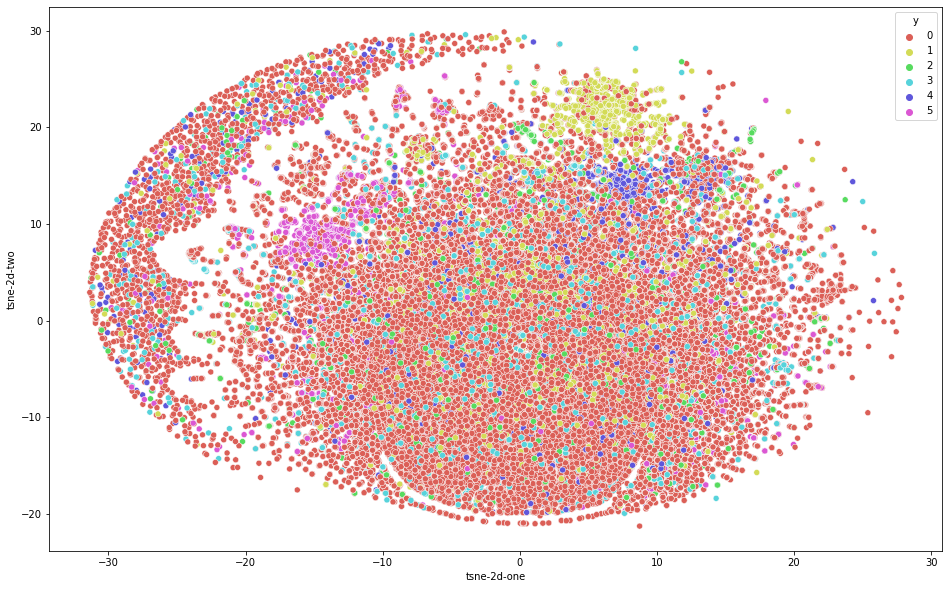

In [113]:
df_tsne = pd.DataFrame()
df_tsne['tsne-2d-one'] = X_reduced[:,0]
df_tsne['tsne-2d-two'] = X_reduced[:,1]
df_tsne['y'] = kmeans.labels_

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", df_tsne['y'].nunique()),
    data=df_tsne,
    legend="full",
);